# <span style="color:red">Importing Data and getting initial info</span>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns

from unidecode import unidecode
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from wordcloud import WordCloud
from string import punctuation

# UNCOMMENT THIS PART WHEN RUNNING THIS NOTEBOOK FOR THE FIRST TIME
# nltk.download() 

In [2]:
data = pd.read_csv("./data/feed_2020-02-24.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            1000 non-null   int64 
 1   Title         1000 non-null   object
 2   Image         1000 non-null   object
 3   Link          1000 non-null   object
 4   Category      1000 non-null   object
 5   Content       1000 non-null   object
 6   Created at    1000 non-null   object
 7   Updated at    1000 non-null   object
 8   Button text   997 non-null    object
 9   Pick count    1000 non-null   int64 
 10  Collectible   1000 non-null   bool  
 11  Published at  1000 non-null   object
 12  Platform      1000 non-null   object
dtypes: bool(1), int64(2), object(10)
memory usage: 94.9+ KB


# <span style="color:red">Data Pre-processing</span>

In [4]:
feed_news = data.query('Category == "news"').copy()
feed_news = feed_news[['Id', 'Title', 'Content']]

### Creating a column with title and content together

In [5]:
feed_news['Title_and_Content'] = feed_news['Title'] + ' ' + feed_news['Content']

### Transforming text to lower_case

In [6]:
feed_news['Title_and_Content'] = feed_news['Title_and_Content'].str.lower()

### Removing stopwords

In [7]:
pattern = r'\b(?:{})\b'.format('|'.join(stopwords.words('portuguese'))) 
feed_news['Without_stopwords'] = feed_news['Title_and_Content'].str.replace(pattern, '')

### Removing punctuations

In [8]:
def remove_punctuations(text):
    punctuations = list(punctuation)
    text_chars = list(text)
    
    for char in text_chars:
        text_chars.remove(char) if char in punctuations else None

    return ''.join(text_chars)

In [9]:
feed_news['Without_punctuations'] = feed_news['Without_stopwords'].apply(remove_punctuations)

### Removing accents

In [10]:
def remove_accents(text):
    return unidecode(text)

In [11]:
feed_news['Without_accents'] = feed_news['Without_punctuations'].apply(remove_accents)

### Removing morphological affixes from words (Stemmer)

In [12]:
def stem_words(text):    
    tokenizer = WordPunctTokenizer()
    stemmer = RSLPStemmer()
    words = tokenizer.tokenize(text)
    stemmed_words = map(lambda word : stemmer.stem(word), words)

    return ' '.join(stemmed_words)

In [13]:
feed_news['Without_morphological_affixes'] = feed_news['Without_accents'].apply(stem_words)
feed_news

,Id,Title,Content,Title_and_Content,Without_stopwords,Without_punctuations,Without_accents,Without_morphological_affixes
0,1,Ex-executiva fala sobre vida sem propósito - I...,Esqueça o que te disseram sobre a zona de conf...,ex-executiva fala sobre vida sem propósito - i...,ex-executiva fala sobre vida propósito - ibc ...,exexecutiva fala sobre vida propósito ibc co...,exexecutiva fala sobre vida proposito ibc co...,exexecu fal sobr vid proposit ibc coaching esq...
1,3,Todos os casos registrados em 10 anos por dele...,"Em dez anos, 465 vítimas – uma a cada semana, ...",todos os casos registrados em 10 anos por dele...,todos casos registrados 10 anos delegacia e...,todos casos registrados 10 anos delegacia e...,todos casos registrados 10 anos delegacia e...,tod cas registr 10 ano delegac especi g1 dez a...
2,6,13 razões pelas quais crianças são bem mais es...,Temos muito o que aprender com elas.,13 razões pelas quais crianças são bem mais es...,13 razões quais crianças bem espertas gen...,13 razões quais crianças bem espertas gen...,13 razoes quais criancas bem espertas gen...,13 razo qual crianc bem espert gent aprend
3,7,Conheça a PHC,Pelo fim da desnutrição no mundo - ONGs que ap...,conheça a phc pelo fim da desnutrição no mundo...,conheça phc fim desnutrição mundo - ongs ...,conheça phc fim desnutrição mundo ongs a...,conheca phc fim desnutricao mundo ongs a...,conhec phc fim desnutrica mund ong apoi
4,8,11 coisas que você não sabia que era capaz de ...,Buzzfeed: Mas que a gente tem certeza que você...,11 coisas que você não sabia que era capaz de ...,11 coisas sabia capaz fazer buzzfeed: ...,11 coisas sabia capaz fazer buzzfeed ...,11 coisas sabia capaz fazer buzzfeed ...,11 cois sab capaz faz buzzfeed gent cert conseg
...,...,...,...,...,...,...,...,...
991,1194,Por que é importante meditar?,"Assim como qualquer pessoa, você provavelmente...",por que é importante meditar? assim como qualq...,"importante meditar? assim qualquer pessoa,...",importante meditar assim qualquer pessoa ...,importante meditar assim qualquer pessoa ...,import medit assim qualqu pesso prova acord pe...
992,1195,Chegou sua hora de ser um Assinante Ribonito!,Experimente a assinatura de ribons pela metade...,chegou sua hora de ser um assinante ribonito! ...,chegou hora ser assinante ribonito! experim...,chegou hora ser assinante ribonito experime...,chegou hora ser assinante ribonito experime...,cheg hor ser assin ribonit experim assinat rib...
994,1197,As vencedoras deste concurso de fotografias de...,Andamos tão obcecados pelas novas tecnologias ...,as vencedoras deste concurso de fotografias de...,vencedoras deste concurso fotografias paisa...,vencedoras deste concurso fotografias paisa...,vencedoras deste concurso fotografias paisa...,venc dest concurs fotograf pais parec fotograf...
996,1199,Bloco de carnaval de BH tem bateria formada po...,Uma bateria bastante especial faz o maior suce...,bloco de carnaval de bh tem bateria formada po...,bloco carnaval bh bateria formada pessoas ...,bloco carnaval bh bateria formada pessoas ...,bloco carnaval bh bateria formada pessoas ...,bloc carnav bh bat form pesso deficienc bat ba...


# <span style="color:red">WordClouds and Frequency Distributions</span>

### Function to generate wordclouds given a text

In [14]:
def generate_wordcloud(text, figsize=(20,8)):
    wordcloud = WordCloud(max_words=100, 
                          width=900,
                          height=500,
                          max_font_size=350,
                          collocations=False,
                          normalize_plurals=False).generate(text)
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Function to get the full content and title in one string

In [15]:
def full_content_and_title(series):
    return series.str.cat(sep=" ")

### Function to generate a frequency distribution 

In [16]:
def generate_freq_dist_plot(text, max_words=25):
    words = WordPunctTokenizer().tokenize(text)
    words_that_apper_the_most = pd.Series(words).value_counts().nlargest(max_words)

    ax = sns.barplot(x=words_that_apper_the_most.index, y=words_that_apper_the_most.values)
    ax.figure.set_size_inches(20, 7)
    
    return words_that_apper_the_most

### For raw data

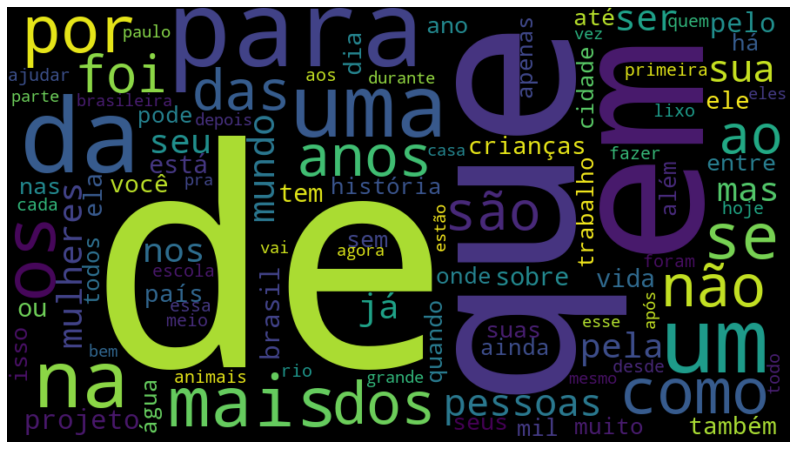

,       5340
de      4773
.       3231
a       3093
e       2691
o       2425
que     2005
em      1500
do      1454
para    1425
da      1336
um       993
com      979
uma      943
é        896
no       879
na       784
os       631
mais     603
as       543
por      505
se       495
como     476
-        437
não      409
dtype: int64

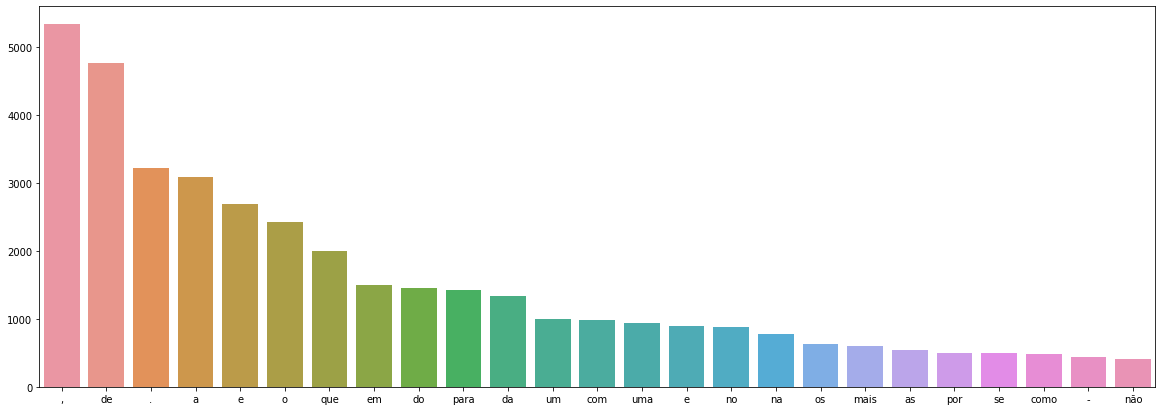

In [17]:
text = full_content_and_title(feed_news['Title_and_Content'])

generate_wordcloud(text)
generate_freq_dist_plot(text)

### Without stop  words

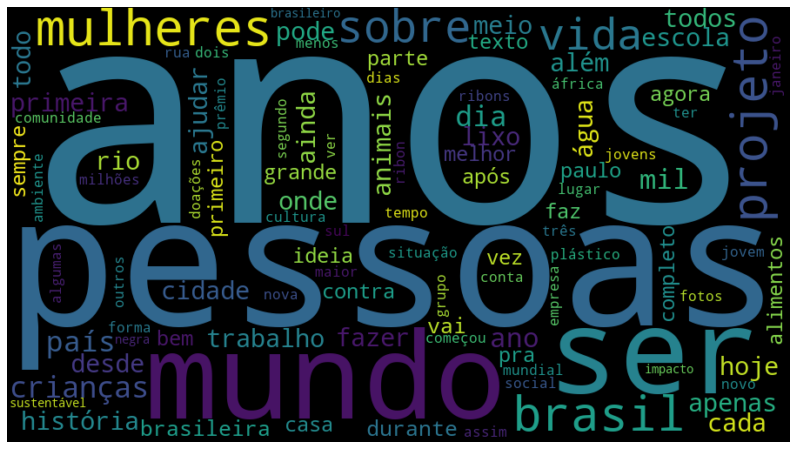

,           5335
.           3227
-            417
anos         373
“            308
(            299
:            287
pessoas      258
mundo        232
–            231
ser          229
!            213
mulheres     202
projeto      197
brasil       187
sobre        163
vida         158
crianças     144
dia          138
país         137
)            136
mil          128
”,           125
?            121
ano          120
dtype: int64

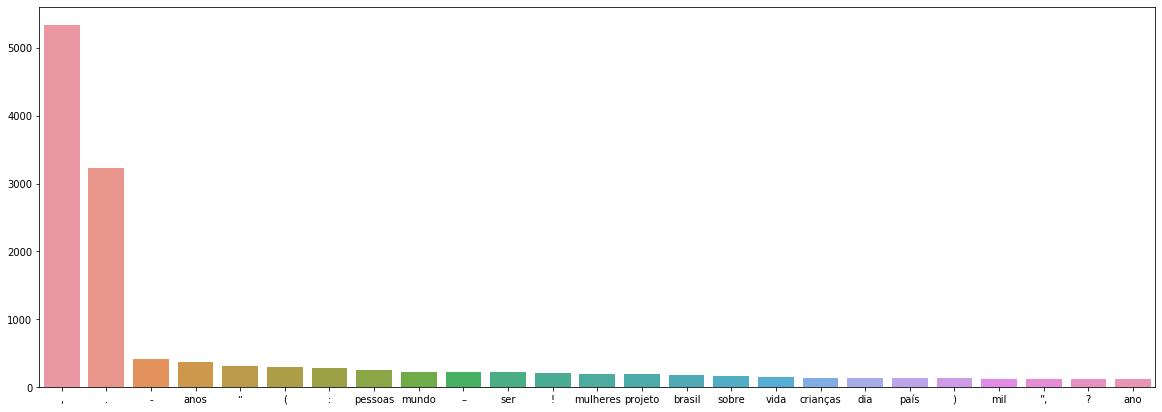

In [18]:
text = full_content_and_title(feed_news['Without_stopwords'])

generate_wordcloud(text)
generate_freq_dist_plot(text)

### Without punctuations

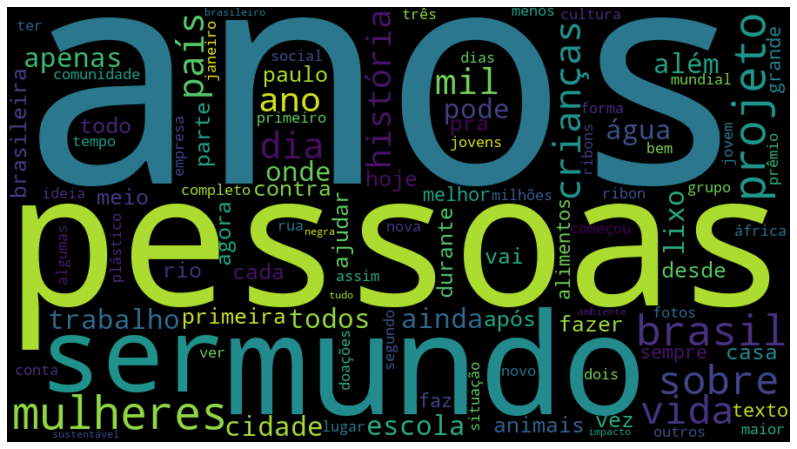

anos        372
“           322
”           295
pessoas     258
–           233
mundo       232
ser         229
mulheres    202
projeto     197
brasil      185
sobre       163
vida        158
crianças    144
dia         138
país        137
’           132
mil         128
,           126
ano         120
‘           116
.           111
história    108
apenas      105
pode        104
todos       101
dtype: int64

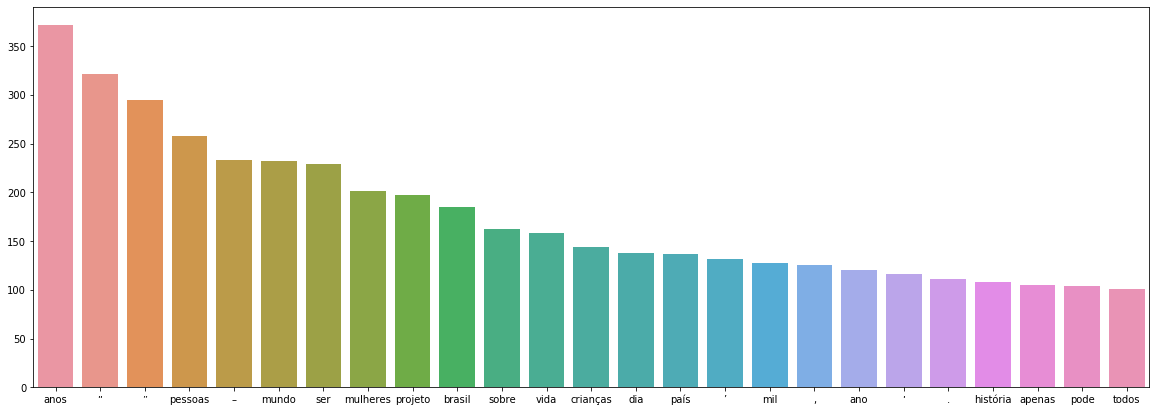

In [19]:
text = full_content_and_title(feed_news['Without_punctuations'])

generate_wordcloud(text)
generate_freq_dist_plot(text)

### Without accents

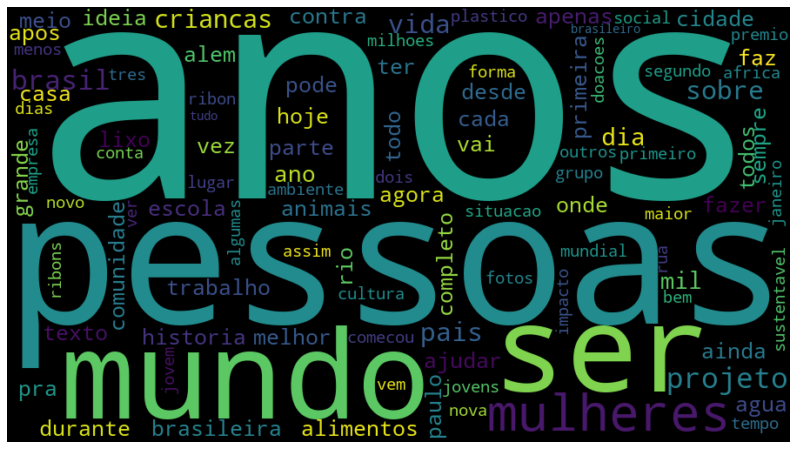

"           628
anos        372
pessoas     258
'           250
-           239
mundo       232
ser         229
mulheres    202
projeto     197
brasil      185
sobre       163
vida        158
pais        155
criancas    144
dia         138
mil         128
,           126
ano         120
.           111
historia    108
pode        105
apenas      105
todos       101
agua         99
alem         99
dtype: int64

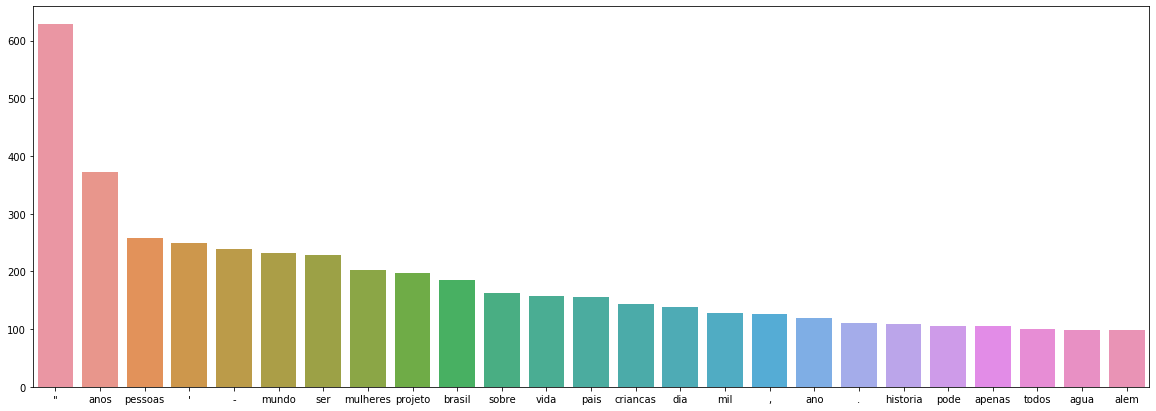

In [20]:
text = full_content_and_title(feed_news['Without_accents'])
generate_wordcloud(text)
generate_freq_dist_plot(text)

### Without morphological affixes (Stemmed)

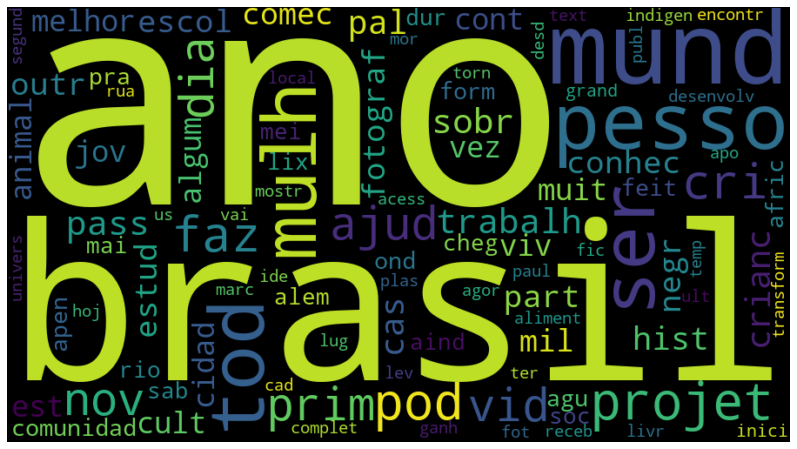

"          628
ano        492
brasil     392
mund       300
pesso      279
tod        262
ser        254
'          250
mulh       246
-          239
projet     235
pod        220
faz        214
cri        208
dia        200
prim       185
nov        182
vid        181
trabalh    180
ajud       180
sobr       177
pass       177
crianc     165
cas        157
pal        155
dtype: int64

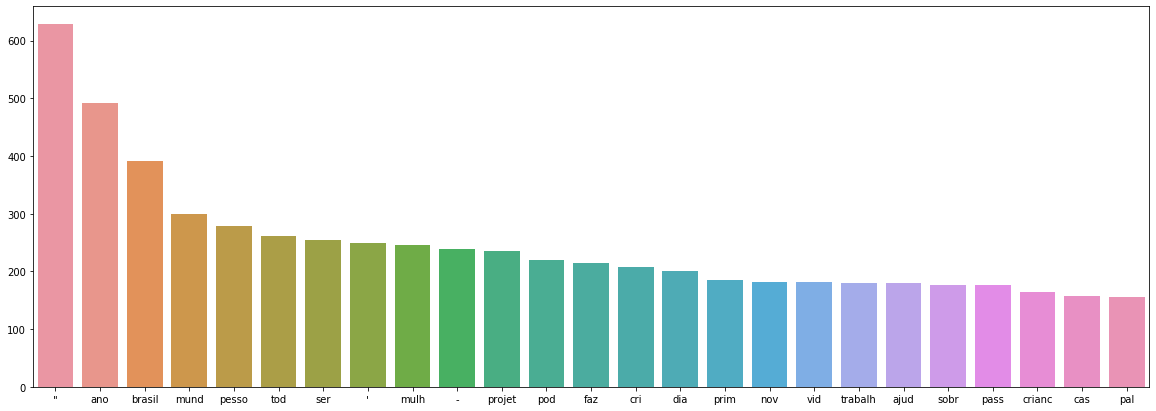

In [21]:
text = full_content_and_title(feed_news['Without_morphological_affixes'])
generate_wordcloud(text)
generate_freq_dist_plot(text)